In [2]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import sys
sys.path.append('../../tools/')
import fitting_functions

import matplotlib.colors

import matplotlib.ticker as ticker

import os
import scipy.optimize
import tqdm.notebook

In [4]:
# Set rcParams
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [5]:
def deconvolveEyePos(trange, eye_pos, plant, ind=-1):
    plant_model = fitting_functions.exponentialModel(trange, plant)
    dt = trange[2]-trange[1]
    
    def convMat(signal, m):
        mat = np.zeros((len(signal), m))
        mat[:,0] = signal
        for i in range(1, m):
            mat[i:,i] = signal[:len(signal)-i]
        return mat
    
    if ind == -1:
        ind = len(trange)
    mat = dt*convMat(plant_model, ind)
    optresult = scipy.optimize.lsq_linear(mat, eye_pos, bounds=(0, np.inf))
    f_ = np.zeros(len(trange))
    f_[:len(optresult.x)] = optresult.x
    return f_

def exponentialModelConvolved(trange, params, k_cirf):
    dt = trange[1] - trange[0]
    impulse = np.zeros(len(trange))
    impulse[0] = 1./dt*params[-1];
    exp_model = fitting_functions.exponentialModel(trange, params[:-1])
    cirf = fitting_functions.exponentialModel(trange,np.array([1, k_cirf]))
    return dt*np.convolve(exp_model+impulse, cirf)[:len(exp_model)]


def calculateR2(trange, fluo, fit, k_cirf):
    mu = np.mean(fluo)
    sstot = np.sum((fluo - mu)**2)
    sse = np.sum((fluo - exponentialModelConvolved(trange, fit, k_cirf))**2)
    return 1 - sse/sstot 

def R2(data,fit):
    try:
        x = data.shape[0]
        sstot = np.sum((fit - np.mean(data))**2)
        sse = np.sum((fit - data)**2)
    except:
        sstot = np.sum([np.sum((fit[i] - np.mean(data[i]))**2) for i in range(len(data))])
        sse = np.sum([np.sum((fit[i] - data[i])**2) for i in range(len(data))])
    return 1-sse/sstot

In [6]:
file_names_fluo = ('110309FISH1', '110609FISH1',
             '111209FISH2', '111309FISH1', '111509FISH1', '111609FISH4')

# Calculate neural drive for saccadic eye position

In [7]:
# Load summary plant
plant_file = sio.loadmat('../active/plants/summary-plant.mat')
summary_plant = plant_file['plant'][0]

In [8]:
# Load true eye position
eyepos_ipsi_all_raw = [[],]*len(file_names_fluo)
T_start = 0
T_end = 4097

for i in range(len(file_names_fluo)):
    data_file = sio.loadmat('../../data/cells/fluo/' + file_names_fluo[i] + '.mat')
    ipsi_pos = data_file['ipsiSTAE6'][0]-data_file['null_pos'][0][0]
    ipsi_peak = np.argmax(ipsi_pos)
    eyepos_ipsi_all_raw[i] = ipsi_pos[ipsi_peak:]/ipsi_pos[ipsi_peak]
T_end = np.min([len(eyepos_ipsi_all_raw[i]) for i in range(len(file_names_fluo))])

In [9]:
# Load fits to eye position
trange = np.arange(0, T_end, 1)*2e-3
eyepos_ipsi_fits = np.zeros((len(file_names_fluo), len(trange)))
for i in range(len(file_names_fluo)):   
    fit_file = sio.loadmat('../../data/cells/eye/'+file_names_fluo[i]+'.mat')
    fit = fit_file['fit'][0]
    eyepos_ipsi_fits[i] = fitting_functions.exponentialModel(trange, fit)

In [10]:
f_summary_individual = np.zeros((len(file_names_fluo), len(trange)))
for i in tqdm.notebook.trange(len(file_names_fluo)):
    f_summary_individual[i] = deconvolveEyePos(trange, eyepos_ipsi_fits[i], summary_plant)

In [11]:
T_start = 125 # 250 ms

# Load cell firing rates

In [12]:
cell_fr = np.zeros((151, len(trange)))
auc_fr = np.zeros(151)

ss_ratio_cutoff = 7e-3

j = 0
for i in range(len(file_names_fluo)):
    filename = file_names_fluo[i]
    data_file = sio.loadmat('../../data/cells/fluo/'+filename+'.mat')
    fluo_ipsi = data_file['FluoIpsi']
    eyepos_ipsi = data_file['ipsiSTAE6'][0]-data_file['null_pos'][0][0]
    fluo_contra = data_file['FluoContra']
    
    fluo_ipsi_means = np.mean(fluo_ipsi[1537-1000:1537-500,:], axis=0)
    fluo_contra_means= np.mean(fluo_contra[1537+2000:1537+2500,:], axis=0)
    fluo_means = np.minimum(fluo_ipsi_means, fluo_contra_means)

    ipsi_peak = np.argmax(eyepos_ipsi)

    trange_full = np.arange(0, 2e-3*4097, 2e-3)

    fit_file_ipsi = sio.loadmat('fit/results/'+filename+'_ipsi.mat')
    best_fits_ipsi_fish = fit_file_ipsi['fits'][0]
    k_cirf = fit_file_ipsi['k_cirf'][0]
    indices = fit_file_ipsi['indices'][0]
    
    for k in range(len(best_fits_ipsi_fish)):
        ind = indices[k]
        best_fit_ = best_fits_ipsi_fish[k][0]
        fluo = fluo_ipsi[:,ind]-fluo_means[ind]
        model = exponentialModelConvolved(trange_full[:-ipsi_peak],best_fit_, k_cirf[k])
        ss_ratio_ = np.sum((fluo[ipsi_peak:]-model)**2)/np.sum((fluo[ipsi_peak:])**2)
        
        if ss_ratio_ < ss_ratio_cutoff:
            cell_fr[j,:] = fitting_functions.exponentialModel(trange, best_fit_[:-1])
            auc_fr[j] = np.sum(cell_fr[j,T_start:]/cell_fr[j,T_start])/len(cell_fr[j,T_start:])
            j+= 1

# Fit neural drive with cells

In [13]:
def binarySearchNeuronFitExcitatory(A, b, inds_, lmb_max = 10, lmb_min = 0, iter_lim = 20, termination_range = [0.1499, 0.1501], pos_thresh = 1e-4, verbose=False):
    lmb_ = 0.5*(lmb_max + lmb_min)
    termination_range = np.array(termination_range)
    A_ = A[:, inds_]
    num_cells = len(inds_)
    
    for i in range(iter_lim):
        AA = np.vstack((A_, np.sqrt(lmb_*(len(b)-1))*np.eye(len(inds_))))
        w_, err_ = scipy.optimize.nnls(AA, np.concatenate((b, np.zeros(len(inds_)))))
        pct_pos = np.sum(w_ > pos_thresh)/num_cells
        if verbose:
            print("Iteration",i+1,"\% pos:",pct_pos)

        if termination_range[0] < pct_pos < termination_range[1]:
            break
        elif pct_pos > termination_range[1]:
            lmb_max = lmb_
        elif pct_pos < termination_range[0]:
            lmb_min = lmb_
        lmb_ = 0.5*(lmb_min + lmb_max)

    return w_, lmb_, pct_pos, err_

In [14]:
n_cells = cell_fr.shape[0]
sort_inds = np.argsort(auc_fr)

cells_sorted = cell_fr[sort_inds,T_start:]

In [15]:
ws_total = np.zeros((len(file_names_fluo), n_cells))
lmbs_ = np.zeros(len(file_names_fluo))
for i in tqdm.notebook.trange(len(file_names_fluo)):
    b_ind = f_summary_individual[i][T_start:]/f_summary_individual[i][T_start]
    w_exc, lmb_exc, pct_pos, err_exc = binarySearchNeuronFitExcitatory(cells_sorted.T, b_ind, np.arange(n_cells), 
                                                                   termination_range=[0.49,0.51], verbose=False)
    ws_total[i,:] = w_exc
    lmbs_[i] = lmb_exc

## Fit quality

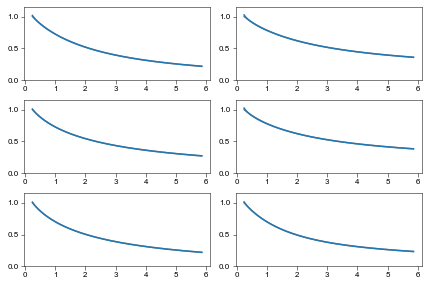

In [118]:
r2s_neural_drive = np.zeros(len(file_names_fluo))
for i in range(len(file_names_fluo)):
    b_ind = f_summary_individual[i][T_start:]/f_summary_individual[i][T_start]
    plt.subplot(3,2,i+1)
    plt.plot(trange[T_start:], b_ind, c=(0.5,0.5,0.5))
    plt.plot(trange[T_start:], ws_total[i,:]@cells_sorted)
    plt.ylim([0,1.15])
    r2s_neural_drive[i] = R2(b_ind, ws_total[i,:]@cells_sorted)
plt.tight_layout()

In [119]:
np.median(r2s_neural_drive)

0.9998774179495775

In [120]:
np.min(r2s_neural_drive), np.max(r2s_neural_drive)

(0.9997095168522353, 0.9999370280497154)

## Weights

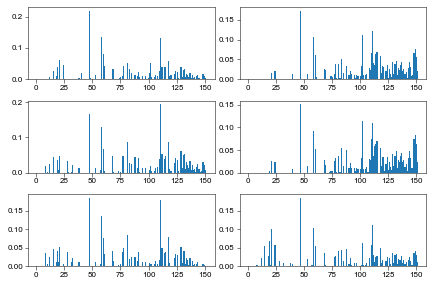

In [121]:
for i in range(len(file_names_fluo)):
    plt.subplot(3,2,i+1)
    plt.bar(np.arange(n_cells)+1, ws_total[i,:],1)
plt.tight_layout()

In [122]:
np.mean([np.sum(ws_total[i,:]>0)/n_cells for i in range(len(file_names_fluo))])

0.5022075055187638

### Figure 9F

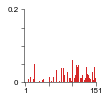

In [134]:
plt.figure(figsize=(1.3, 1.3))
plt.bar(np.arange(n_cells), np.mean(ws_total,axis=0), 1, color='C3')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.linspace(0, n_cells, 4))
ax.set_xticklabels([1, '','', n_cells])
plt.xlim([-3, n_cells])

ax.set_yticks(np.linspace(0, 0.2, 5))
ax.set_yticklabels([0, '', '','',0.2 ])

plt.subplots_adjust(left=0.21, bottom=0.18, right=0.98, top=0.96)

# Mock population fits

In [92]:
n_cells_mock = 150
its = 100

trange_models = np.copy(trange[:-T_start])
best_fits_mock = np.zeros((6, its, len(trange_models)))

inds = np.arange(6) # [5,3]
for k in tqdm.notebook.trange(len(inds)):
    j = inds[k]
    b_ind = f_summary_individual[j][T_start:]/f_summary_individual[j][T_start]
    for it in tqdm.notebook.trange(its, leave=False):
        # generate random time constants
        taus_long= np.power(10, 1.3+0.7*np.random.rand(n_cells_mock//2))
        taus_short = np.random.rand(n_cells_mock//2)

        taus = np.concatenate((taus_short, taus_long))

        models = np.zeros((n_cells_mock, len(trange_models)))
        mock_aucs = np.zeros(n_cells_mock)

        for i in range(n_cells_mock):
            models[i] = np.exp(-trange_models/taus[i])
            mock_aucs[i] = np.sum(models[i])/len(trange_models)   

        mock_cells_sorted = np.argsort(mock_aucs)
        mock_aucs_sorted = mock_aucs[mock_cells_sorted]
        models_sorted = models[mock_cells_sorted,:]

        w_exc_mock, lmb_exc_mock, pct_pos_mock, err_exc_mock = binarySearchNeuronFitExcitatory(models_sorted.T, b_ind, np.arange(n_cells_mock),
                                                                       termination_range=[0.49,0.51], verbose=False)

        best_fits_mock[j, it,:] = w_exc_mock@models_sorted

In [94]:
best_fits_confidence = np.zeros((6,len(trange_models), 2))
best_fits_median = np.zeros((6,len(trange_models)))
for i in range(6):
    best_fits_confidence[i,:,0] = np.percentile(best_fits_mock[i,:,:], 2.5, axis=0)
    best_fits_confidence[i,:,1] = np.percentile(best_fits_mock[i,:,:], 97.5, axis=0)
    best_fits_median[i,:] = np.median(best_fits_mock[i,:,:], axis=0)

In [97]:
# Load saved version

mock_summary_file = sio.loadmat('mock/mock-populations.mat')
best_fits_confidence = mock_summary_file['confidence']
best_fits_median = mock_summary_file['medians']

In [108]:
mse_ratios = np.zeros(6)
persistences_ind = np.zeros(6)
for i in range(6):
    b_ind = f_summary_individual[i][T_start:]/f_summary_individual[i][T_start]
    mse_mock = np.mean((best_fits_median[i,:] - b_ind)**2)
    mse_data = np.mean((ws_total[i,:]@cells_sorted - b_ind)**2)
    mse_ratios[i] = mse_mock/mse_data
    persistences_ind[i] = np.sum(b_ind)/len(b_ind)

In [104]:
np.median(mse_ratios)

506.20877974161385

In [105]:
np.min(mse_ratios), np.max(mse_ratios)

(163.2696388451141, 977.8229666230634)

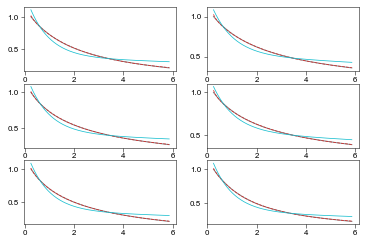

In [107]:
for i in range(len(file_names_fluo)):
    b_ind = f_summary_individual[i][T_start:T_end]/f_summary_individual[i][T_start]
    plt.subplot(3,2,i+1)
    plt.plot(trange[T_start:], b_ind, c=(0.5,0.5,0.5), lw=1)
    plt.plot(trange[T_start:], ws_total[i,:]@cells_sorted, c='C3', lw=0.75, ls='--')
    plt.plot(trange[T_start:], best_fits_median[i,:], c='C9',lw=0.75)

## Figure 9E: reconstruction of neural drive

In [110]:
np.argsort(persistences_ind)

array([5, 4, 0, 2, 1, 3])

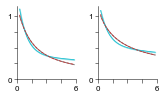

In [112]:
plt.figure(figsize=(2.2, 1.3))
# colors = ['C3', 'C9']
inds = [5,3]
for i in range(len(inds)):
    ax = plt.subplot(1,2,i+1)
    j = inds[i]
    b_ind = f_summary_individual[j][T_start:T_end]/f_summary_individual[j][T_start]
    plt.plot(trange[T_start:], b_ind, c=(0.5, 0.5, 0.5, 1), lw=1, label='Neural drive estimate')
    
    
    plt.fill_between(trange[T_start:], best_fits_confidence[i,:,0], best_fits_confidence[i,:,1], color='C9', alpha=0.3)
    plt.plot(trange[T_start:], best_fits_median[i,:], c='C9', lw=0.75)

    plt.plot(trange[T_start:], ws_total[j,:]@cells_sorted, '--', c='C3', lw=0.75, label='Regularized fit to cells')

    ax = plt.gca()
    # ax.text(1,0.8, r'$R^2 = %.3f$' % R2(b_ind, ws_total[i,:]@cells_sorted), color='C3', ha='right',transform=ax.transAxes)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, 1.15])
    # plt.xlabel('Time after saccade end (s)')
    # plt.ylabel('Normalized neural drive')
    ax.set_yticks(np.linspace(0, 1, 5))
    ax.set_yticklabels([0,'','','',1])
    plt.xlim([0, 6])
    ax.set_xticks(np.linspace(0, 6, 5))
    ax.set_xticklabels([0, '', '', '', 6])
plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.18, right=0.98, top=0.96)